# Importing the libraries

In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame
from pandas import concat
from pandas import Series
from pandas.plotting import lag_plot

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import max_error
from sklearn.metrics import r2_score
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU
from keras.layers import Dropout

import math
from math import sqrt

from matplotlib import pyplot
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

import warnings
warnings.filterwarnings("ignore")

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True' 

# Loading dataset

In [2]:
# flight_4 = pd.read_csv("Combined_Data_Apr21.csv")
# flight_5 = pd.read_csv("Combined_Data_May21.csv")
# flight_6 = pd.read_csv("Combined_Data_Jun21.csv")
# flight_4 = flight_4.append(flight_5)
# flight_4 = flight_4.append(flight_6)

In [3]:
flight_4 = pd.read_csv("Combined_Data_All.csv")

In [4]:
light = flight_4[["Timestamp", "Num_Flights", "Num_Covid_Cases"]]

In [5]:
light

,Timestamp,Num_Flights,Num_Covid_Cases
0,2020-01-22,38,0.0
1,2020-01-22,5,0.0
2,2020-01-22,17,0.0
3,2020-01-22,208,0.0
4,2020-01-22,116,0.0
...,...,...,...
44247,2022-01-31,4,23063.0
44248,2022-01-31,32,2028.0
44249,2022-01-31,54,848962.0
44250,2022-01-31,4736,527140.0


In [6]:
data = light.groupby(by=["Timestamp"]).sum()
data.reset_index()
data

,Num_Flights,Num_Covid_Cases
Timestamp,,
2020-01-22,7545,655.0
2020-01-23,8979,98.0
2020-01-24,9124,286.0
2020-01-25,7654,492.0
2020-01-26,6751,684.0
...,...,...
2022-01-27,8174,3122335.0
2022-01-28,8376,3138982.0
2022-01-29,6924,2146044.0


In [7]:
data.to_csv('data.csv')

# Visualizing train data

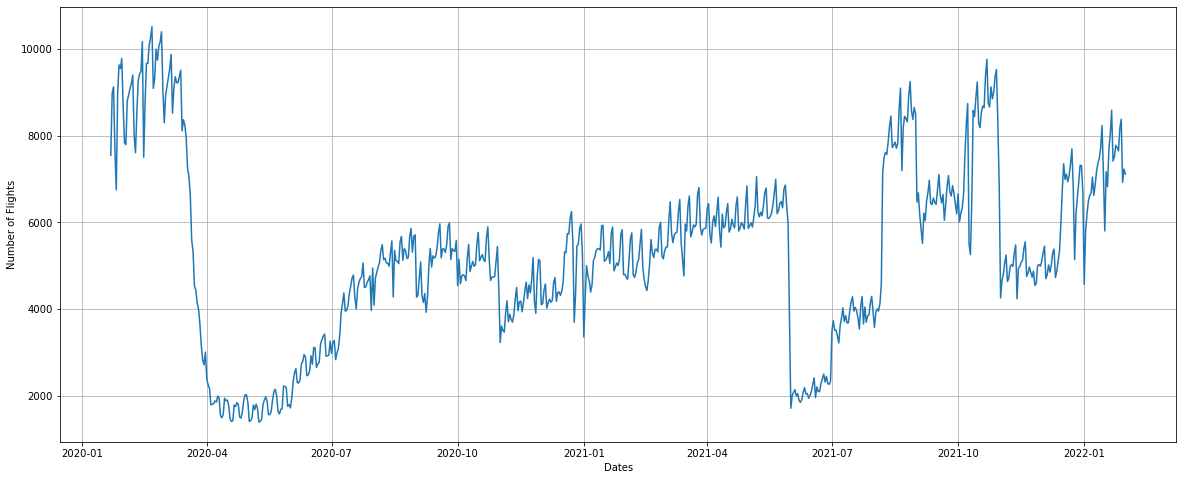

In [8]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
data = pd.read_csv('data.csv', sep=',', parse_dates=['Timestamp'], index_col='Timestamp',date_parser=dateparse)
plt.figure(figsize=(20,8))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Number of Flights')
plt.plot(data['Num_Flights']);
plt.show()

# Plotting autocorrelation

No handles with labels found to put in legend.


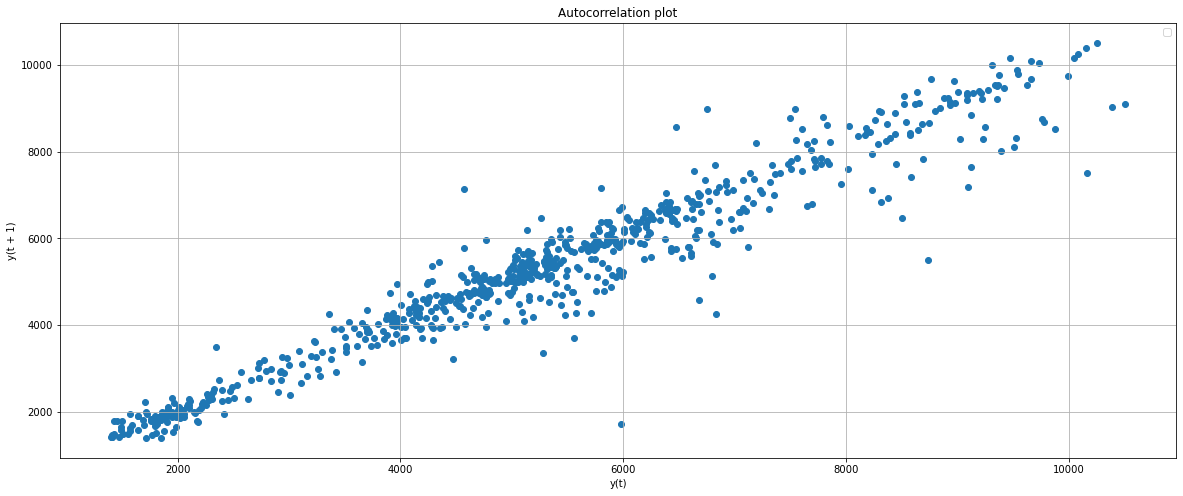

In [9]:
plt.figure(figsize=(20,8))
lag_plot(data['Num_Flights'], lag=1)
plt.title('Autocorrelation plot')
plt.grid(True)
plt.legend();

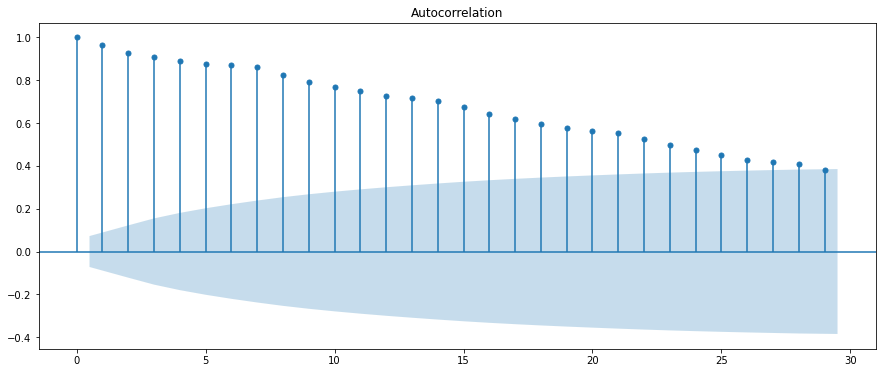

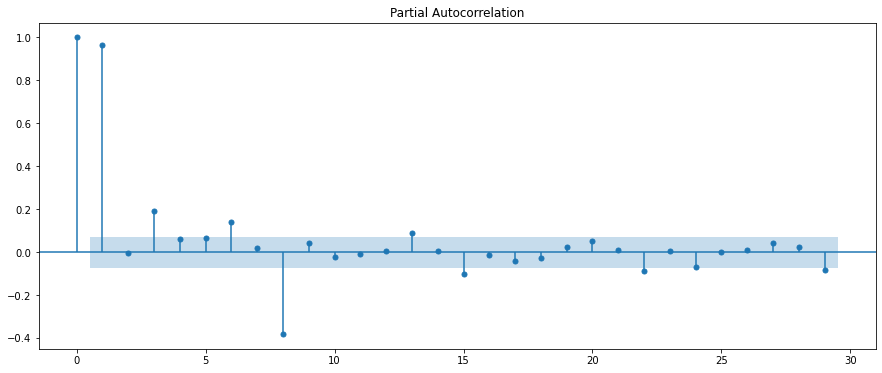

In [10]:
fig1=plot_acf(data['Num_Flights'].dropna()) 
fig2=plot_pacf(data['Num_Flights'].dropna()) 

In [11]:
values = DataFrame(data['Num_Flights'].values)
dataframe = concat([values.shift(120), values], axis=1)
dataframe.columns = ['t-1', 't+1']
result = dataframe.corr()
print(result)

          t-1       t+1
t-1  1.000000 -0.224504
t+1 -0.224504  1.000000


In [12]:
data.tail()

,Num_Flights,Num_Covid_Cases
Timestamp,,
2022-01-27,8174,3122335.0
2022-01-28,8376,3138982.0
2022-01-29,6924,2146044.0
2022-01-30,7230,1842602.0
2022-01-31,7112,3197167.0


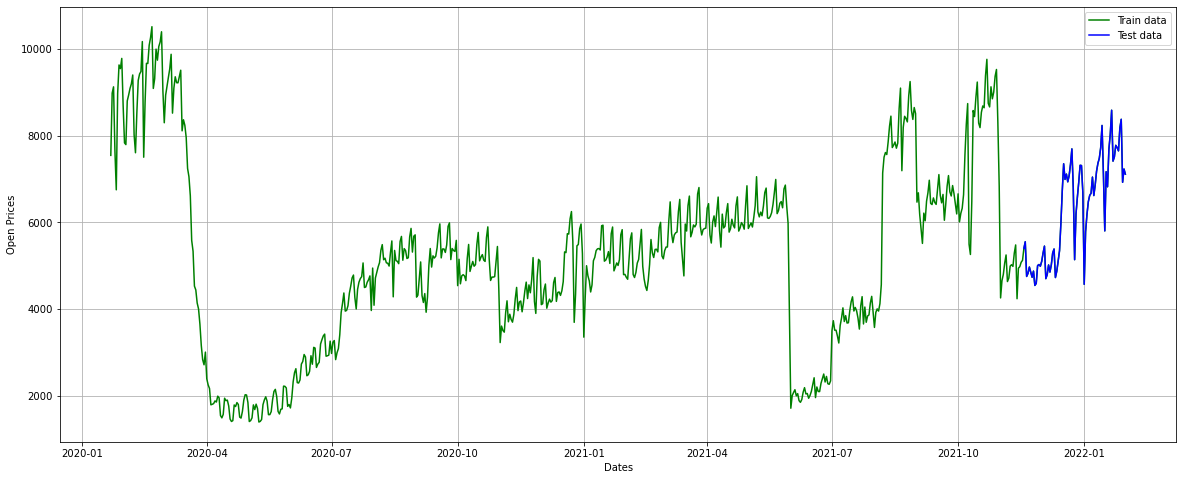

In [13]:
train_data, test_data = data[0:int(len(data)*0.9)], data[int(len(data)*0.9):]
plt.figure(figsize=(20,8))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Open Prices')
plt.plot(data['Num_Flights'], 'green', label='Train data')
plt.plot(test_data['Num_Flights'], 'blue', label='Test data')
plt.legend()

# Autoregression model

In [14]:
train_ar = train_data['Num_Flights']
test_ar = test_data['Num_Flights']

# train autoregression
model = AR(train_ar)
model_fit = model.fit()
window = model_fit.k_ar
coef = model_fit.params

In [15]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               AR Model Results                               
==============================================================================
Dep. Variable:                      N  -                  u                  m
Model:                         AR(19)   Log Likelihood               -4861.095
Method:                          cmle   S.D. of innovations            464.557
Date:                Wed, 13 Apr 2022   AIC                             12.347
Time:                        23:09:30   BIC                             12.493
Sample:                             0   HQIC                            12.404
                                                                              
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             152.9280     53.710      2.847      0.004      47.659     258.197
L1.Num_Flights      0.9505      0.040     23.727      0.000       0.872       1.029
L2.Num_Flights     -0.1172      0.055     -2.122      0.034      -0.225      -0.009
L3.Num_Flights      0.0849      0.055      1.536      0.124      -0.023       0.193
L4.Num_Flights      0.0420      0.055      0.758      0.448      -0.067       0.150
L5.Num_Flights     -0.0268      0.056     -0.482      0.630      -0.136       0.082
L6.Num_Flights      0.0285      0.056      0.513      0.608      -0.080       0.137
L7.Num_Flights      0.3317      0.055      5.985      0.000       0.223       0.440
L8.Num_Flights     -0.3601      0.057     -6.336      0.000      -0.471      -0.249
L9.Num_Flights      0.0673      0.059      1.149      0.250      -0.047       0.182
L10.Num_Flights    -0.0612      0.059     -1.045      0.296      -0.176       0.054
L11.Num_Flights     0.0407      0.059      0.695      0.487      -0.074       0.155
L12.Num_Flights    -0.0639      0.057     -1.127      0.260      -0.175       0.047
L13.Num_Flights     0.0675      0.055      1.225      0.220      -0.040       0.175
L14.Num_Flights     0.1022      0.055      1.858      0.063      -0.006       0.210
L15.Num_Flights    -0.1038      0.055     -1.897      0.058      -0.211       0.003
L16.Num_Flights     0.0033      0.055      0.061      0.952      -0.104       0.111
L17.Num_Flights     0.0132      0.055      0.238      0.812      -0.096       0.122
L18.Num_Flights    -0.0469      0.055     -0.846      0.397      -0.155       0.062
L19.Num_Flights     0.0170      0.040      0.422      0.673      -0.062       0.096
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1            -1.0014           -0.4668j            1.1048           -0.4306
AR.2            -1.0014           +0.4668j            1.1048            0.4306
AR.3            -1.3092           -0.2952j            1.3421           -0.4647
AR.4            -1.3092           +0.2952j            1.3421            0.4647
AR.5            -0.7416           -0.9246j            1.1853           -0.3576
AR.6            -0.7416           +0.9246j            1.1853            0.3576
AR.7            -0.2544           -1.0358j            1.0666           -0.2883
AR.8            -0.2544           +1.0358j            1.0666            0.2883
AR.9             1.0580           -0.0000j            1.0580           -0.0000
AR.10            1.0767           -0.0000j            1.0767           -0.0000
AR.11            1.0910           -0.4994j            1.1998           -0.0683
AR.12            1.0910           +0.4994j            1.1998            0.0683
AR.13            0.6754           -0.8363j   

In [16]:
# walk forward over time steps in test
history = train_ar[len(train_ar)-window:]
history

Timestamp
2021-10-30    8313
2021-10-31    6834
2021-11-01    4260
2021-11-02    4657
2021-11-03    4801
2021-11-04    5063
2021-11-05    5250
2021-11-06    4637
2021-11-07    4717
2021-11-08    4994
2021-11-09    5025
2021-11-10    4986
2021-11-11    5293
2021-11-12    5481
2021-11-13    4241
2021-11-14    4945
2021-11-15    4980
2021-11-16    5081
2021-11-17    5126
Name: Num_Flights, dtype: int64

In [17]:
history = [history[i] for i in range(len(history))]

In [18]:
predictions = list()

In [19]:
for t in range(len(test_ar)):
    length = len(history)
    lag = [history[i] for i in range(length-window,length)]
    yhat = coef[0]
    for d in range(window):
        yhat += coef[d+1] * lag[window-d-1]
    obs = test_ar[t]
    predictions.append(yhat)
    history.append(obs)

Lag: 19


Text(0, 0.5, 'Number of Flights')

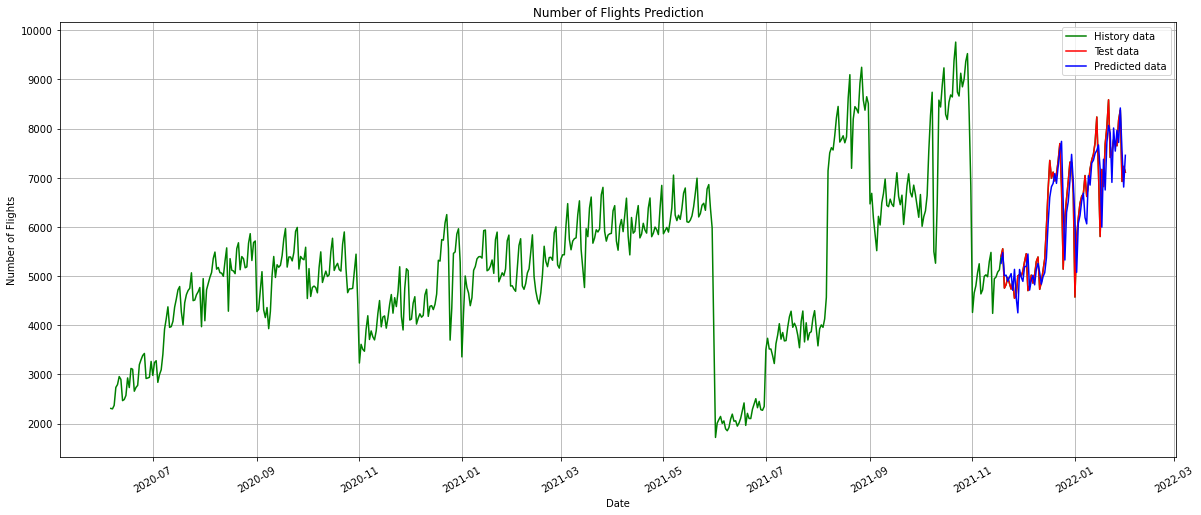

In [20]:
plt.figure(figsize=(20,8))
print('Lag: %s' % model_fit.k_ar)
plt.plot(data.index[-600:], data['Num_Flights'].tail(600), color='green', label='History data')#, marker = 'x')
plt.plot(test_data.index, test_data['Num_Flights'], color='red', label='Test data')#, marker = '.')
plt.plot(test_data.index, predictions, color='blue', label='Predicted data')#, marker = '*')
plt.xticks(rotation=30)
plt.grid(True)
plt.legend()
plt.title('Number of Flights Prediction')
plt.xlabel('Date')
plt.ylabel('Number of Flights')

# Performance and Evaluation

In [21]:
mse = mean_squared_error(test_data['Num_Flights'], predictions)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data['Num_Flights'], predictions)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data['Num_Flights'], predictions))
print('RMSE: '+str(rmse))
me = max_error(test_data['Num_Flights'], predictions)
print('ME: '+str(me))
score = r2_score(test_data['Num_Flights'], predictions)
print('r2 score: '+str(score))
result = adfuller(data['Num_Flights'])
dict(zip(['adf', 'pvalue', 'usedlag', 'nobs', 'critical' 'values', 'icbest'],result))

plt.savefig('ar_model.pdf')

MSE: 259351.99393512908
MAE: 381.05087645883066
RMSE: 509.26613271955273
ME: 1530.0953505458483
r2 score: 0.8080750062883586


<Figure size 1080x432 with 0 Axes>

In [22]:
predictions

[5257.913641972099,
 5474.985982128635,
 5006.628488366261,
 5017.6932426734975,
 4895.789664327534,
 5049.670502571978,
 4708.340792087863,
 5136.177664932445,
 4565.787183327263,
 4251.808201293988,
 5133.607305716404,
 4977.463162339074,
 4892.226508009975,
 5189.6958304094915,
 5196.1064991918565,
 5448.994817952524,
 4713.794913809888,
 4916.3783027915715,
 5017.109867851219,
 4821.821597961068,
 5136.737489109926,
 5256.532917497726,
 5070.772384205084,
 4836.196851041929,
 4987.2043396619665,
 5067.316506452778,
 5367.966383863784,
 6051.505154030477,
 6602.1106082189945,
 6816.179830666515,
 6883.961846390358,
 7083.699341930476,
 6884.943780966623,
 7232.873309375781,
 7551.381082111906,
 7739.218208314432,
 6497.243775357112,
 5326.011003909777,
 6295.412965167435,
 6511.738955520667,
 6934.9557586651135,
 7474.489406158218,
 6920.097520795358,
 6103.095350545848,
 5075.679363302501,
 6071.79513380853,
 6231.472441494792,
 6520.208011386929,
 6685.4166737755195,
 6188.1726508

In [23]:
ar_df = pd.DataFrame(predictions)
ar_df.to_csv('ar_predictions.csv')